In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import math
import gym
import random
import numpy as np
import matplotlib.pyplot as plt

env = gym.make('CartPole-v1')
observation_space = env.observation_space.shape[0]
action_space = env.action_space.n

EPISODES = 500
EPISODES_TEST = int(EPISODES/2)
LEARNING_RATE = 0.0001
MEM_SIZE = 10000
BATCH_SIZE = 32
GAMMA = 0.95
EXPLORATION_MAX = 1.0
EXPLORATION_DECAY = 0.999
EXPLORATION_MIN = 0.001


FC1_DIMS = 1024
FC2_DIMS = 512
DEVICE = torch.device("cpu")



In [2]:
class Network(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.input_shape = env.observation_space.shape
        self.action_space = action_space

        self.fc1 = nn.Linear(*self.input_shape, FC1_DIMS)
        self.fc2 = nn.Linear(FC1_DIMS, FC2_DIMS)
        self.fc3 = nn.Linear(FC2_DIMS, self.action_space)

        self.optimizer = optim.Adam(self.parameters(), lr=LEARNING_RATE)
        self.loss = nn.MSELoss()
        self.to(DEVICE)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class ReplayBuffer:
    def __init__(self):
        self.mem_count = 0

        self.states = np.zeros((MEM_SIZE, *env.observation_space.shape),dtype=np.float32)
        self.actions = np.zeros(MEM_SIZE, dtype=np.int64)
        self.rewards = np.zeros(MEM_SIZE, dtype=np.float32)
        self.states_ = np.zeros((MEM_SIZE, *env.observation_space.shape),dtype=np.float32)
        self.dones = np.zeros(MEM_SIZE, dtype=np.bool)

    def add(self, state, action, reward, state_, done):
        mem_index = self.mem_count % MEM_SIZE

        self.states[mem_index]  = state.clone().detach().numpy()
        self.actions[mem_index] = action
        self.rewards[mem_index] = reward
        self.states_[mem_index] = state_.clone().detach().numpy()
        self.dones[mem_index] =  1 - done

        self.mem_count += 1

    def sample(self):
        MEM_MAX = min(self.mem_count, MEM_SIZE)
        batch_indices = np.random.choice(MEM_MAX, BATCH_SIZE, replace=True)

        states  = self.states[batch_indices]
        actions = self.actions[batch_indices]
        rewards = self.rewards[batch_indices]
        states_ = self.states_[batch_indices]
        dones   = self.dones[batch_indices]

        return states, actions, rewards, states_, dones

class DQN_Solver:
    def __init__(self):
        self.memory = ReplayBuffer()
        self.exploration_rate = EXPLORATION_MAX
        self.network = Network()

    def choose_action(self, observation, eps_greedy=True):
        if eps_greedy and random.random() < self.exploration_rate:
            return env.action_space.sample(), 0.0

        state = observation
        state = state.to(DEVICE)
        state = state.unsqueeze(0)

        q_values = self.network(state)
        return torch.argmax(q_values).item(), q_values

    def learn(self):
        if self.memory.mem_count < BATCH_SIZE:
            return

        states, actions, rewards, states_, dones = self.memory.sample()
        states = torch.tensor(states , dtype=torch.float32).to(DEVICE)
        actions = torch.tensor(actions, dtype=torch.long).to(DEVICE)
        rewards = torch.tensor(rewards, dtype=torch.float32).to(DEVICE)
        states_ = torch.tensor(states_, dtype=torch.float32).to(DEVICE)
        dones = torch.tensor(dones, dtype=torch.bool).to(DEVICE)

        batch_indices = np.arange(BATCH_SIZE, dtype=np.int64)
        states.requires_grad = True
        
        q_values = self.network(states)
        next_q_values = self.network(states_)

        predicted_value_of_now = q_values[batch_indices, actions]
        predicted_value_of_future = torch.max(next_q_values, dim=1)[0].detach()
        
        q_target = rewards + GAMMA * predicted_value_of_future * dones
#         print(rewards)

        loss = self.network.loss(q_target, predicted_value_of_now)        
        self.network.optimizer.zero_grad()
        loss.backward()
        self.network.optimizer.step()

        self.exploration_rate *= EXPLORATION_DECAY
        self.exploration_rate = max(EXPLORATION_MIN, self.exploration_rate)

    def returning_epsilon(self):
        return self.exploration_rate

## Training the network

In [3]:
agent = DQN_Solver()
agent.network.train()

best_reward = 0
average_reward = 0
episode_number = []
average_reward_number = []

for i in range(1, EPISODES):
    state = env.reset()
    score = 0

    while True:
        action, q_values = agent.choose_action(state)
        
        state_, reward, done, info = env.step(action)
        agent.memory.add(state, action, reward, state_, done)
        agent.learn()
        state = state_
        score += reward

        if done:
            if score > best_reward:
                best_reward = score
            average_reward += score
            print("Episode {} Average Reward {} Best Reward {} Last Reward {} Epsilon {}".format(i, average_reward/i, best_reward, score, agent.returning_epsilon()))
            break

        episode_number.append(i)
        average_reward_number.append(average_reward/i)


/tmp/ipykernel_10091/2150234180.py:29: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.dones = np.zeros(MEM_SIZE, dtype=np.bool)


Episode 1 Average Reward 9.0 Best Reward 9.0 Last Reward 9.0 Epsilon 1.0
Episode 2 Average Reward 14.5 Best Reward 20.0 Last Reward 20.0 Epsilon 1.0
Episode 3 Average Reward 13.666666666666666 Best Reward 20.0 Last Reward 12.0 Epsilon 0.9900448802097482
Episode 4 Average Reward 16.25 Best Reward 24.0 Last Reward 24.0 Epsilon 0.9665550620990835
Episode 5 Average Reward 20.0 Best Reward 35.0 Last Reward 35.0 Epsilon 0.933294459381294
Episode 6 Average Reward 20.166666666666668 Best Reward 35.0 Last Reward 21.0 Epsilon 0.9138900318559524
Episode 7 Average Reward 19.428571428571427 Best Reward 35.0 Last Reward 15.0 Epsilon 0.9002772252562138
Episode 8 Average Reward 22.0 Best Reward 40.0 Last Reward 40.0 Epsilon 0.8649595394300645
Episode 9 Average Reward 23.22222222222222 Best Reward 40.0 Last Reward 33.0 Epsilon 0.8368678892362568
Episode 10 Average Reward 25.9 Best Reward 50.0 Last Reward 50.0 Epsilon 0.7960334462988972
Episode 11 Average Reward 24.818181818181817 Best Reward 50.0 Last 

Episode 84 Average Reward 255.70238095238096 Best Reward 500.0 Last Reward 384.0 Epsilon 0.001
Episode 85 Average Reward 256.7294117647059 Best Reward 500.0 Last Reward 343.0 Epsilon 0.001
Episode 86 Average Reward 258.9186046511628 Best Reward 500.0 Last Reward 445.0 Epsilon 0.001
Episode 87 Average Reward 259.9655172413793 Best Reward 500.0 Last Reward 350.0 Epsilon 0.001
Episode 88 Average Reward 260.9318181818182 Best Reward 500.0 Last Reward 345.0 Epsilon 0.001
Episode 89 Average Reward 262.6179775280899 Best Reward 500.0 Last Reward 411.0 Epsilon 0.001
Episode 90 Average Reward 264.4555555555556 Best Reward 500.0 Last Reward 428.0 Epsilon 0.001
Episode 91 Average Reward 265.8021978021978 Best Reward 500.0 Last Reward 387.0 Epsilon 0.001
Episode 92 Average Reward 268.3478260869565 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 93 Average Reward 269.8494623655914 Best Reward 500.0 Last Reward 408.0 Epsilon 0.001
Episode 94 Average Reward 271.17021276595744 Best Reward 50

Episode 171 Average Reward 322.5438596491228 Best Reward 500.0 Last Reward 391.0 Epsilon 0.001
Episode 172 Average Reward 322.72093023255815 Best Reward 500.0 Last Reward 353.0 Epsilon 0.001
Episode 173 Average Reward 322.78034682080926 Best Reward 500.0 Last Reward 333.0 Epsilon 0.001
Episode 174 Average Reward 323.52298850574715 Best Reward 500.0 Last Reward 452.0 Epsilon 0.001
Episode 175 Average Reward 323.6 Best Reward 500.0 Last Reward 337.0 Epsilon 0.001
Episode 176 Average Reward 323.84090909090907 Best Reward 500.0 Last Reward 366.0 Epsilon 0.001
Episode 177 Average Reward 323.96045197740114 Best Reward 500.0 Last Reward 345.0 Epsilon 0.001
Episode 178 Average Reward 323.87640449438203 Best Reward 500.0 Last Reward 309.0 Epsilon 0.001
Episode 179 Average Reward 324.21787709497204 Best Reward 500.0 Last Reward 385.0 Epsilon 0.001
Episode 180 Average Reward 324.30555555555554 Best Reward 500.0 Last Reward 340.0 Epsilon 0.001
Episode 181 Average Reward 324.55801104972375 Best Rew

Episode 258 Average Reward 296.62015503875966 Best Reward 500.0 Last Reward 187.0 Epsilon 0.001
Episode 259 Average Reward 296.42471042471044 Best Reward 500.0 Last Reward 246.0 Epsilon 0.001
Episode 260 Average Reward 295.9769230769231 Best Reward 500.0 Last Reward 180.0 Epsilon 0.001
Episode 261 Average Reward 296.03065134099614 Best Reward 500.0 Last Reward 310.0 Epsilon 0.001
Episode 262 Average Reward 296.08015267175574 Best Reward 500.0 Last Reward 309.0 Epsilon 0.001
Episode 263 Average Reward 295.93155893536124 Best Reward 500.0 Last Reward 257.0 Epsilon 0.001
Episode 264 Average Reward 296.28409090909093 Best Reward 500.0 Last Reward 389.0 Epsilon 0.001
Episode 265 Average Reward 295.7207547169811 Best Reward 500.0 Last Reward 147.0 Epsilon 0.001
Episode 266 Average Reward 295.6015037593985 Best Reward 500.0 Last Reward 264.0 Epsilon 0.001
Episode 267 Average Reward 295.41198501872657 Best Reward 500.0 Last Reward 245.0 Epsilon 0.001
Episode 268 Average Reward 294.981343283582

Episode 345 Average Reward 264.07246376811594 Best Reward 500.0 Last Reward 153.0 Epsilon 0.001
Episode 346 Average Reward 263.73988439306356 Best Reward 500.0 Last Reward 149.0 Epsilon 0.001
Episode 347 Average Reward 263.2190201729107 Best Reward 500.0 Last Reward 83.0 Epsilon 0.001
Episode 348 Average Reward 262.89942528735634 Best Reward 500.0 Last Reward 152.0 Epsilon 0.001
Episode 349 Average Reward 262.3896848137536 Best Reward 500.0 Last Reward 85.0 Epsilon 0.001
Episode 350 Average Reward 262.0342857142857 Best Reward 500.0 Last Reward 138.0 Epsilon 0.001
Episode 351 Average Reward 261.45014245014244 Best Reward 500.0 Last Reward 57.0 Epsilon 0.001
Episode 352 Average Reward 260.9630681818182 Best Reward 500.0 Last Reward 90.0 Epsilon 0.001
Episode 353 Average Reward 260.7082152974504 Best Reward 500.0 Last Reward 171.0 Epsilon 0.001
Episode 354 Average Reward 260.5734463276836 Best Reward 500.0 Last Reward 213.0 Epsilon 0.001
Episode 355 Average Reward 260.34647887323945 Best

Episode 432 Average Reward 248.09722222222223 Best Reward 500.0 Last Reward 180.0 Epsilon 0.001
Episode 433 Average Reward 247.88452655889145 Best Reward 500.0 Last Reward 156.0 Epsilon 0.001
Episode 434 Average Reward 247.65898617511522 Best Reward 500.0 Last Reward 150.0 Epsilon 0.001
Episode 435 Average Reward 247.44137931034481 Best Reward 500.0 Last Reward 153.0 Epsilon 0.001
Episode 436 Average Reward 247.29128440366972 Best Reward 500.0 Last Reward 182.0 Epsilon 0.001
Episode 437 Average Reward 247.12356979405035 Best Reward 500.0 Last Reward 174.0 Epsilon 0.001
Episode 438 Average Reward 246.99086757990867 Best Reward 500.0 Last Reward 189.0 Epsilon 0.001
Episode 439 Average Reward 246.75854214123007 Best Reward 500.0 Last Reward 145.0 Epsilon 0.001
Episode 440 Average Reward 246.5590909090909 Best Reward 500.0 Last Reward 159.0 Epsilon 0.001
Episode 441 Average Reward 246.40362811791383 Best Reward 500.0 Last Reward 178.0 Epsilon 0.001
Episode 442 Average Reward 246.1764705882

## Testing the network

In [4]:
def attack_FGSM(state, epsilon):
    state.requires_grad_()
    q_values = agent.network(state)
    index_worst_case = torch.argmin(q_values)
    loss_softmax = -torch.log(torch.softmax(q_values,0)[index_worst_case])
    gradient_sign = torch.autograd.grad(loss_softmax,state,retain_graph=True)[0].sign()
    pert_state = state + gradient_sign * epsilon
    return pert_state.detach()


In [5]:
agent.network.eval()

best_reward = 0

episode_number = []
average_reward_number_attacked = []
epsilons_attacks = np.arange(0,0.4,0.05)

for epsilon in epsilons_attacks:
    average_reward_attacked = 0
    print("NEW ATTACK STARTING, MAGNTIUDE (EPISLON) IS:", epsilon)
    for i in range(1,EPISODES_TEST):
        state = env.reset()
        score = 0
        did_pertubate = 0
        while True:
            #env.render()
            pert_state = attack_FGSM(state, epsilon)
            action, q_values = agent.choose_action(pert_state,eps_greedy= False)
            state_, reward, done, info = env.step(action)

            state = state_.detach()
            score += reward

            if done:            
                if score > best_reward:
                    best_reward = score
                average_reward_attacked += score
                print("Episode {} Average Reward {} Best Reward {} Last Reward {} Epsilon {}".format(i, average_reward_attacked/i, best_reward, score, agent.returning_epsilon()))
                break

            episode_number.append(i)
    
    average_reward_number_attacked.append(average_reward_attacked / i)
    



NEW ATTACK STARTING, MAGNTIUDE (EPISLON) IS: 0.0
Episode 1 Average Reward 218.0 Best Reward 218.0 Last Reward 218.0 Epsilon 0.001
Episode 2 Average Reward 268.5 Best Reward 319.0 Last Reward 319.0 Epsilon 0.001
Episode 3 Average Reward 282.0 Best Reward 319.0 Last Reward 309.0 Epsilon 0.001
Episode 4 Average Reward 294.0 Best Reward 330.0 Last Reward 330.0 Epsilon 0.001
Episode 5 Average Reward 335.2 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 6 Average Reward 350.3333333333333 Best Reward 500.0 Last Reward 426.0 Epsilon 0.001
Episode 7 Average Reward 357.7142857142857 Best Reward 500.0 Last Reward 402.0 Epsilon 0.001
Episode 8 Average Reward 375.5 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 9 Average Reward 389.3333333333333 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 10 Average Reward 376.4 Best Reward 500.0 Last Reward 260.0 Epsilon 0.001
Episode 11 Average Reward 380.54545454545456 Best Reward 500.0 Last Reward 422.0 Epsilon 0.001
Episode 1

Episode 90 Average Reward 429.3 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 91 Average Reward 429.25274725274727 Best Reward 500.0 Last Reward 425.0 Epsilon 0.001
Episode 92 Average Reward 430.0217391304348 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 93 Average Reward 428.3010752688172 Best Reward 500.0 Last Reward 270.0 Epsilon 0.001
Episode 94 Average Reward 429.06382978723406 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 95 Average Reward 429.81052631578945 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 96 Average Reward 430.5416666666667 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 97 Average Reward 428.4845360824742 Best Reward 500.0 Last Reward 231.0 Epsilon 0.001
Episode 98 Average Reward 428.7040816326531 Best Reward 500.0 Last Reward 450.0 Epsilon 0.001
Episode 99 Average Reward 429.010101010101 Best Reward 500.0 Last Reward 459.0 Epsilon 0.001
Episode 100 Average Reward 427.19 Best Reward 500.0 Last Reward 247.0 

Episode 178 Average Reward 423.19662921348316 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 179 Average Reward 423.00558659217876 Best Reward 500.0 Last Reward 389.0 Epsilon 0.001
Episode 180 Average Reward 423.43333333333334 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 181 Average Reward 423.8563535911602 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 182 Average Reward 424.27472527472526 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 183 Average Reward 423.46994535519127 Best Reward 500.0 Last Reward 277.0 Epsilon 0.001
Episode 184 Average Reward 422.79891304347825 Best Reward 500.0 Last Reward 300.0 Epsilon 0.001
Episode 185 Average Reward 421.6972972972973 Best Reward 500.0 Last Reward 219.0 Epsilon 0.001
Episode 186 Average Reward 421.7204301075269 Best Reward 500.0 Last Reward 426.0 Epsilon 0.001
Episode 187 Average Reward 421.19251336898395 Best Reward 500.0 Last Reward 323.0 Epsilon 0.001
Episode 188 Average Reward 421.611702127659

Episode 16 Average Reward 410.3125 Best Reward 500.0 Last Reward 380.0 Epsilon 0.001
Episode 17 Average Reward 401.52941176470586 Best Reward 500.0 Last Reward 261.0 Epsilon 0.001
Episode 18 Average Reward 407.0 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 19 Average Reward 411.89473684210526 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 20 Average Reward 411.1 Best Reward 500.0 Last Reward 396.0 Epsilon 0.001
Episode 21 Average Reward 412.57142857142856 Best Reward 500.0 Last Reward 442.0 Epsilon 0.001
Episode 22 Average Reward 416.54545454545456 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 23 Average Reward 420.17391304347825 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 24 Average Reward 413.25 Best Reward 500.0 Last Reward 254.0 Epsilon 0.001
Episode 25 Average Reward 406.6 Best Reward 500.0 Last Reward 247.0 Epsilon 0.001
Episode 26 Average Reward 404.15384615384613 Best Reward 500.0 Last Reward 343.0 Epsilon 0.001
Episode 27 Avera

Episode 105 Average Reward 415.26666666666665 Best Reward 500.0 Last Reward 428.0 Epsilon 0.001
Episode 106 Average Reward 416.0660377358491 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 107 Average Reward 416.85046728971963 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 108 Average Reward 415.0 Best Reward 500.0 Last Reward 217.0 Epsilon 0.001
Episode 109 Average Reward 415.7798165137615 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 110 Average Reward 416.54545454545456 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 111 Average Reward 417.2972972972973 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 112 Average Reward 416.25 Best Reward 500.0 Last Reward 300.0 Epsilon 0.001
Episode 113 Average Reward 416.9911504424779 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 114 Average Reward 417.719298245614 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 115 Average Reward 417.69565217391306 Best Reward 500.0 Last Re

Episode 192 Average Reward 422.921875 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 193 Average Reward 423.30051813471505 Best Reward 500.0 Last Reward 496.0 Epsilon 0.001
Episode 194 Average Reward 423.6958762886598 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 195 Average Reward 423.9846153846154 Best Reward 500.0 Last Reward 480.0 Epsilon 0.001
Episode 196 Average Reward 424.3724489795918 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 197 Average Reward 424.1319796954315 Best Reward 500.0 Last Reward 377.0 Epsilon 0.001
Episode 198 Average Reward 424.5151515151515 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 199 Average Reward 424.89447236180905 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 200 Average Reward 425.175 Best Reward 500.0 Last Reward 481.0 Epsilon 0.001
Episode 201 Average Reward 424.44776119402985 Best Reward 500.0 Last Reward 279.0 Epsilon 0.001
Episode 202 Average Reward 423.8019801980198 Best Reward 500.0 L

Episode 31 Average Reward 406.0967741935484 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 32 Average Reward 409.03125 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 33 Average Reward 408.3030303030303 Best Reward 500.0 Last Reward 385.0 Epsilon 0.001
Episode 34 Average Reward 402.70588235294116 Best Reward 500.0 Last Reward 218.0 Epsilon 0.001
Episode 35 Average Reward 400.42857142857144 Best Reward 500.0 Last Reward 323.0 Epsilon 0.001
Episode 36 Average Reward 403.19444444444446 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 37 Average Reward 405.81081081081084 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 38 Average Reward 408.2894736842105 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 39 Average Reward 403.2564102564103 Best Reward 500.0 Last Reward 212.0 Epsilon 0.001
Episode 40 Average Reward 404.05 Best Reward 500.0 Last Reward 435.0 Epsilon 0.001
Episode 41 Average Reward 406.390243902439 Best Reward 500.0 Last Reward 50

Episode 119 Average Reward 425.5378151260504 Best Reward 500.0 Last Reward 287.0 Epsilon 0.001
Episode 120 Average Reward 423.78333333333336 Best Reward 500.0 Last Reward 215.0 Epsilon 0.001
Episode 121 Average Reward 424.41322314049586 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 122 Average Reward 425.0327868852459 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 123 Average Reward 424.7479674796748 Best Reward 500.0 Last Reward 390.0 Epsilon 0.001
Episode 124 Average Reward 425.0403225806452 Best Reward 500.0 Last Reward 461.0 Epsilon 0.001
Episode 125 Average Reward 425.328 Best Reward 500.0 Last Reward 461.0 Epsilon 0.001
Episode 126 Average Reward 425.41269841269843 Best Reward 500.0 Last Reward 436.0 Epsilon 0.001
Episode 127 Average Reward 425.4488188976378 Best Reward 500.0 Last Reward 430.0 Epsilon 0.001
Episode 128 Average Reward 426.03125 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 129 Average Reward 426.6046511627907 Best Reward 500.0 La

Episode 206 Average Reward 422.49029126213594 Best Reward 500.0 Last Reward 389.0 Epsilon 0.001
Episode 207 Average Reward 422.8647342995169 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 208 Average Reward 423.2355769230769 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 209 Average Reward 423.2870813397129 Best Reward 500.0 Last Reward 434.0 Epsilon 0.001
Episode 210 Average Reward 422.3 Best Reward 500.0 Last Reward 216.0 Epsilon 0.001
Episode 211 Average Reward 421.3601895734597 Best Reward 500.0 Last Reward 224.0 Epsilon 0.001
Episode 212 Average Reward 421.7311320754717 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 213 Average Reward 422.09859154929575 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 214 Average Reward 422.4626168224299 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 215 Average Reward 422.45116279069765 Best Reward 500.0 Last Reward 420.0 Epsilon 0.001
Episode 216 Average Reward 421.81481481481484 Best Reward 5

Episode 45 Average Reward 411.35555555555555 Best Reward 500.0 Last Reward 317.0 Epsilon 0.001
Episode 46 Average Reward 410.6304347826087 Best Reward 500.0 Last Reward 378.0 Epsilon 0.001
Episode 47 Average Reward 412.531914893617 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 48 Average Reward 413.1458333333333 Best Reward 500.0 Last Reward 442.0 Epsilon 0.001
Episode 49 Average Reward 410.6938775510204 Best Reward 500.0 Last Reward 293.0 Epsilon 0.001
Episode 50 Average Reward 410.78 Best Reward 500.0 Last Reward 415.0 Epsilon 0.001
Episode 51 Average Reward 410.3529411764706 Best Reward 500.0 Last Reward 389.0 Epsilon 0.001
Episode 52 Average Reward 411.8076923076923 Best Reward 500.0 Last Reward 486.0 Epsilon 0.001
Episode 53 Average Reward 413.47169811320754 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 54 Average Reward 409.74074074074076 Best Reward 500.0 Last Reward 212.0 Epsilon 0.001
Episode 55 Average Reward 411.3818181818182 Best Reward 500.0 Last Re

Episode 133 Average Reward 423.2631578947368 Best Reward 500.0 Last Reward 422.0 Epsilon 0.001
Episode 134 Average Reward 423.3059701492537 Best Reward 500.0 Last Reward 429.0 Epsilon 0.001
Episode 135 Average Reward 422.037037037037 Best Reward 500.0 Last Reward 252.0 Epsilon 0.001
Episode 136 Average Reward 420.5882352941176 Best Reward 500.0 Last Reward 225.0 Epsilon 0.001
Episode 137 Average Reward 421.1678832116788 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 138 Average Reward 420.4782608695652 Best Reward 500.0 Last Reward 326.0 Epsilon 0.001
Episode 139 Average Reward 419.1870503597122 Best Reward 500.0 Last Reward 241.0 Epsilon 0.001
Episode 140 Average Reward 419.0357142857143 Best Reward 500.0 Last Reward 398.0 Epsilon 0.001
Episode 141 Average Reward 419.4609929078014 Best Reward 500.0 Last Reward 479.0 Epsilon 0.001
Episode 142 Average Reward 420.0281690140845 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 143 Average Reward 418.68531468531467 Best 

Episode 220 Average Reward 409.9727272727273 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 221 Average Reward 410.38009049773757 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 222 Average Reward 410.65315315315314 Best Reward 500.0 Last Reward 471.0 Epsilon 0.001
Episode 223 Average Reward 410.6726457399103 Best Reward 500.0 Last Reward 415.0 Epsilon 0.001
Episode 224 Average Reward 411.07142857142856 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 225 Average Reward 411.46666666666664 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 226 Average Reward 411.85840707964604 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 227 Average Reward 412.2466960352423 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 228 Average Reward 412.63157894736844 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 229 Average Reward 412.9170305676856 Best Reward 500.0 Last Reward 478.0 Epsilon 0.001
Episode 230 Average Reward 413.295652173913 

Episode 60 Average Reward 439.51666666666665 Best Reward 500.0 Last Reward 409.0 Epsilon 0.001
Episode 61 Average Reward 439.9836065573771 Best Reward 500.0 Last Reward 468.0 Epsilon 0.001
Episode 62 Average Reward 436.241935483871 Best Reward 500.0 Last Reward 208.0 Epsilon 0.001
Episode 63 Average Reward 436.031746031746 Best Reward 500.0 Last Reward 423.0 Epsilon 0.001
Episode 64 Average Reward 434.8125 Best Reward 500.0 Last Reward 358.0 Epsilon 0.001
Episode 65 Average Reward 432.5076923076923 Best Reward 500.0 Last Reward 285.0 Epsilon 0.001
Episode 66 Average Reward 432.3787878787879 Best Reward 500.0 Last Reward 424.0 Epsilon 0.001
Episode 67 Average Reward 432.0 Best Reward 500.0 Last Reward 407.0 Epsilon 0.001
Episode 68 Average Reward 432.54411764705884 Best Reward 500.0 Last Reward 469.0 Epsilon 0.001
Episode 69 Average Reward 433.5217391304348 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 70 Average Reward 433.1714285714286 Best Reward 500.0 Last Reward 409.0 E

Episode 148 Average Reward 418.4932432432432 Best Reward 500.0 Last Reward 322.0 Epsilon 0.001
Episode 149 Average Reward 417.61744966442956 Best Reward 500.0 Last Reward 288.0 Epsilon 0.001
Episode 150 Average Reward 416.82666666666665 Best Reward 500.0 Last Reward 299.0 Epsilon 0.001
Episode 151 Average Reward 415.9933774834437 Best Reward 500.0 Last Reward 291.0 Epsilon 0.001
Episode 152 Average Reward 415.8355263157895 Best Reward 500.0 Last Reward 392.0 Epsilon 0.001
Episode 153 Average Reward 416.3856209150327 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 154 Average Reward 416.8831168831169 Best Reward 500.0 Last Reward 493.0 Epsilon 0.001
Episode 155 Average Reward 417.4193548387097 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 156 Average Reward 417.39102564102564 Best Reward 500.0 Last Reward 413.0 Epsilon 0.001
Episode 157 Average Reward 417.9171974522293 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 158 Average Reward 418.09493670886076 B

Episode 236 Average Reward 415.83474576271186 Best Reward 500.0 Last Reward 210.0 Epsilon 0.001
Episode 237 Average Reward 416.1898734177215 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 238 Average Reward 415.9117647058824 Best Reward 500.0 Last Reward 350.0 Epsilon 0.001
Episode 239 Average Reward 416.26359832635984 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 240 Average Reward 416.6125 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 241 Average Reward 416.0954356846473 Best Reward 500.0 Last Reward 292.0 Epsilon 0.001
Episode 242 Average Reward 415.8636363636364 Best Reward 500.0 Last Reward 360.0 Epsilon 0.001
Episode 243 Average Reward 416.2098765432099 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 244 Average Reward 416.5532786885246 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 245 Average Reward 415.68163265306123 Best Reward 500.0 Last Reward 203.0 Epsilon 0.001
Episode 246 Average Reward 415.7032520325203 Best Reward

Episode 76 Average Reward 382.10526315789474 Best Reward 500.0 Last Reward 410.0 Epsilon 0.001
Episode 77 Average Reward 383.6363636363636 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 78 Average Reward 385.12820512820514 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 79 Average Reward 386.5822784810127 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 80 Average Reward 383.0625 Best Reward 500.0 Last Reward 105.0 Epsilon 0.001
Episode 81 Average Reward 383.5061728395062 Best Reward 500.0 Last Reward 419.0 Epsilon 0.001
Episode 82 Average Reward 380.2073170731707 Best Reward 500.0 Last Reward 113.0 Epsilon 0.001
Episode 83 Average Reward 380.49397590361446 Best Reward 500.0 Last Reward 404.0 Epsilon 0.001
Episode 84 Average Reward 379.85714285714283 Best Reward 500.0 Last Reward 327.0 Epsilon 0.001
Episode 85 Average Reward 381.2705882352941 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 86 Average Reward 381.7093023255814 Best Reward 500.0 Las

Episode 164 Average Reward 387.9451219512195 Best Reward 500.0 Last Reward 453.0 Epsilon 0.001
Episode 165 Average Reward 386.2181818181818 Best Reward 500.0 Last Reward 103.0 Epsilon 0.001
Episode 166 Average Reward 386.90361445783134 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 167 Average Reward 387.5808383233533 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 168 Average Reward 386.7797619047619 Best Reward 500.0 Last Reward 253.0 Epsilon 0.001
Episode 169 Average Reward 386.8757396449704 Best Reward 500.0 Last Reward 403.0 Epsilon 0.001
Episode 170 Average Reward 385.5764705882353 Best Reward 500.0 Last Reward 166.0 Epsilon 0.001
Episode 171 Average Reward 386.2456140350877 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 172 Average Reward 386.90697674418607 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 173 Average Reward 386.3121387283237 Best Reward 500.0 Last Reward 284.0 Epsilon 0.001
Episode 174 Average Reward 386.9655172413793 Bes

Episode 1 Average Reward 444.0 Best Reward 500.0 Last Reward 444.0 Epsilon 0.001
Episode 2 Average Reward 398.0 Best Reward 500.0 Last Reward 352.0 Epsilon 0.001
Episode 3 Average Reward 300.3333333333333 Best Reward 500.0 Last Reward 105.0 Epsilon 0.001
Episode 4 Average Reward 350.25 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 5 Average Reward 380.2 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 6 Average Reward 395.0 Best Reward 500.0 Last Reward 469.0 Epsilon 0.001
Episode 7 Average Reward 410.0 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 8 Average Reward 392.75 Best Reward 500.0 Last Reward 272.0 Epsilon 0.001
Episode 9 Average Reward 359.55555555555554 Best Reward 500.0 Last Reward 94.0 Epsilon 0.001
Episode 10 Average Reward 352.4 Best Reward 500.0 Last Reward 288.0 Epsilon 0.001
Episode 11 Average Reward 365.1818181818182 Best Reward 500.0 Last Reward 493.0 Epsilon 0.001
Episode 12 Average Reward 376.4166666666667 Best Reward 500.0 Last Re

Episode 91 Average Reward 383.3626373626374 Best Reward 500.0 Last Reward 408.0 Epsilon 0.001
Episode 92 Average Reward 384.6304347826087 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 93 Average Reward 381.6559139784946 Best Reward 500.0 Last Reward 108.0 Epsilon 0.001
Episode 94 Average Reward 382.9148936170213 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 95 Average Reward 383.53684210526313 Best Reward 500.0 Last Reward 442.0 Epsilon 0.001
Episode 96 Average Reward 384.75 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 97 Average Reward 384.7113402061856 Best Reward 500.0 Last Reward 381.0 Epsilon 0.001
Episode 98 Average Reward 385.88775510204084 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 99 Average Reward 387.04040404040404 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 100 Average Reward 386.17 Best Reward 500.0 Last Reward 300.0 Epsilon 0.001
Episode 101 Average Reward 386.16831683168317 Best Reward 500.0 Last Reward 38

Episode 178 Average Reward 386.1179775280899 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 179 Average Reward 386.75418994413405 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 180 Average Reward 386.69444444444446 Best Reward 500.0 Last Reward 376.0 Epsilon 0.001
Episode 181 Average Reward 387.3204419889503 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 182 Average Reward 387.72527472527474 Best Reward 500.0 Last Reward 461.0 Epsilon 0.001
Episode 183 Average Reward 388.3387978142076 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 184 Average Reward 388.10869565217394 Best Reward 500.0 Last Reward 346.0 Epsilon 0.001
Episode 185 Average Reward 388.71351351351353 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 186 Average Reward 387.23118279569894 Best Reward 500.0 Last Reward 113.0 Epsilon 0.001
Episode 187 Average Reward 387.83422459893046 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 188 Average Reward 388.430851063829

Episode 17 Average Reward 398.29411764705884 Best Reward 500.0 Last Reward 497.0 Epsilon 0.001
Episode 18 Average Reward 403.94444444444446 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 19 Average Reward 388.89473684210526 Best Reward 500.0 Last Reward 118.0 Epsilon 0.001
Episode 20 Average Reward 375.35 Best Reward 500.0 Last Reward 118.0 Epsilon 0.001
Episode 21 Average Reward 376.0952380952381 Best Reward 500.0 Last Reward 391.0 Epsilon 0.001
Episode 22 Average Reward 381.72727272727275 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 23 Average Reward 370.04347826086956 Best Reward 500.0 Last Reward 113.0 Epsilon 0.001
Episode 24 Average Reward 375.4583333333333 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 25 Average Reward 380.44 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 26 Average Reward 369.7692307692308 Best Reward 500.0 Last Reward 103.0 Epsilon 0.001
Episode 27 Average Reward 371.1111111111111 Best Reward 500.0 Last Reward 406

Episode 105 Average Reward 375.26666666666665 Best Reward 500.0 Last Reward 294.0 Epsilon 0.001
Episode 106 Average Reward 376.4433962264151 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 107 Average Reward 376.98130841121497 Best Reward 500.0 Last Reward 434.0 Epsilon 0.001
Episode 108 Average Reward 376.3333333333333 Best Reward 500.0 Last Reward 307.0 Epsilon 0.001
Episode 109 Average Reward 373.7155963302752 Best Reward 500.0 Last Reward 91.0 Epsilon 0.001
Episode 110 Average Reward 371.56363636363636 Best Reward 500.0 Last Reward 137.0 Epsilon 0.001
Episode 111 Average Reward 370.98198198198196 Best Reward 500.0 Last Reward 307.0 Epsilon 0.001
Episode 112 Average Reward 372.13392857142856 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 113 Average Reward 373.2654867256637 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 114 Average Reward 374.37719298245617 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 115 Average Reward 375.4695652173913 

Episode 192 Average Reward 388.0625 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 193 Average Reward 388.64248704663214 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 194 Average Reward 388.2628865979381 Best Reward 500.0 Last Reward 315.0 Epsilon 0.001
Episode 195 Average Reward 386.7025641025641 Best Reward 500.0 Last Reward 84.0 Epsilon 0.001
Episode 196 Average Reward 387.28061224489795 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 197 Average Reward 387.8527918781726 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 198 Average Reward 387.3989898989899 Best Reward 500.0 Last Reward 298.0 Epsilon 0.001
Episode 199 Average Reward 387.964824120603 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 200 Average Reward 388.16 Best Reward 500.0 Last Reward 427.0 Epsilon 0.001
Episode 201 Average Reward 388.6865671641791 Best Reward 500.0 Last Reward 494.0 Epsilon 0.001
Episode 202 Average Reward 388.1089108910891 Best Reward 500.0 Last Re

# Plotting

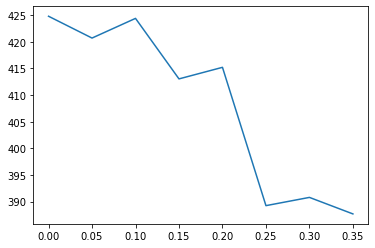

In [6]:
plt.ioff()
plt.figure(1)
plt.plot(epsilons_attacks,average_reward_number_attacked)
plt.show()

## Training with adversarial training

In [16]:
agent_robust = DQN_Solver()
agent_robust.network.train()

best_reward = 0
average_reward = 0
episode_number = []
average_reward_number = []
# EPSILON_PERT_TRAIN = [0.05,0.1,0.15,0.2] #Use later for training with different eps
EPSILON_PERT = 0.05

    
for i in range(1, EPISODES):
    state = env.reset()
    score = 0
    while True:
        pert_state = attack_FGSM(state, EPSILON_PERT)
        action, q_values = agent_robust.choose_action(pert_state)
        state_, reward, done, info = env.step(action)
    
#         if score % 1 == 0 and not(isinstance(q_values,float)):
#             next_q_values = agent.network(state_.to(DEVICE).float()).detach()
#             q_target = reward + GAMMA * next_q_values * done
#             loss = agent.network.loss(q_values, q_target)
#             gradient_sign = torch.autograd.grad(loss,state,retain_graph=True)[0].sign()
#             state = state + gradient_sign * EPSILON_PERT
#             action, q_values = agent.choose_action(state)
#             state_, reward, done, info = env.step(action)
#             did_pertubate += 1
         
                
        agent_robust.memory.add(state, action, reward, state_, done)
        agent_robust.learn()
        state = state_
        score += reward

        if done:
            if score > best_reward:
                best_reward = score
            average_reward += score
            print("Episode {} Average Reward {} Best Reward {} Last Reward {} Epsilon {}".format(i, average_reward/i, best_reward, score, agent.returning_epsilon()))
            break

        episode_number.append(i)
        average_reward_number.append(average_reward/i)

/tmp/ipykernel_10091/2150234180.py:29: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.dones = np.zeros(MEM_SIZE, dtype=np.bool)


Episode 1 Average Reward 16.0 Best Reward 16.0 Last Reward 16.0 Epsilon 0.001
Episode 2 Average Reward 13.0 Best Reward 16.0 Last Reward 10.0 Epsilon 0.001
Episode 3 Average Reward 15.0 Best Reward 19.0 Last Reward 19.0 Epsilon 0.001
Episode 4 Average Reward 14.75 Best Reward 19.0 Last Reward 14.0 Epsilon 0.001
Episode 5 Average Reward 14.4 Best Reward 19.0 Last Reward 13.0 Epsilon 0.001
Episode 6 Average Reward 15.666666666666666 Best Reward 22.0 Last Reward 22.0 Epsilon 0.001
Episode 7 Average Reward 18.0 Best Reward 32.0 Last Reward 32.0 Epsilon 0.001
Episode 8 Average Reward 17.375 Best Reward 32.0 Last Reward 13.0 Epsilon 0.001
Episode 9 Average Reward 17.444444444444443 Best Reward 32.0 Last Reward 18.0 Epsilon 0.001
Episode 10 Average Reward 21.4 Best Reward 57.0 Last Reward 57.0 Epsilon 0.001
Episode 11 Average Reward 20.636363636363637 Best Reward 57.0 Last Reward 13.0 Epsilon 0.001
Episode 12 Average Reward 20.25 Best Reward 57.0 Last Reward 16.0 Epsilon 0.001
Episode 13 Aver

Episode 92 Average Reward 169.07608695652175 Best Reward 473.0 Last Reward 312.0 Epsilon 0.001
Episode 93 Average Reward 171.0 Best Reward 473.0 Last Reward 348.0 Epsilon 0.001
Episode 94 Average Reward 172.20212765957447 Best Reward 473.0 Last Reward 284.0 Epsilon 0.001
Episode 95 Average Reward 174.02105263157895 Best Reward 473.0 Last Reward 345.0 Epsilon 0.001
Episode 96 Average Reward 176.6875 Best Reward 473.0 Last Reward 430.0 Epsilon 0.001
Episode 97 Average Reward 177.62886597938143 Best Reward 473.0 Last Reward 268.0 Epsilon 0.001
Episode 98 Average Reward 178.8877551020408 Best Reward 473.0 Last Reward 301.0 Epsilon 0.001
Episode 99 Average Reward 180.65656565656565 Best Reward 473.0 Last Reward 354.0 Epsilon 0.001
Episode 100 Average Reward 182.3 Best Reward 473.0 Last Reward 345.0 Epsilon 0.001
Episode 101 Average Reward 185.44554455445544 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 102 Average Reward 188.52941176470588 Best Reward 500.0 Last Reward 500.0 Eps

Episode 179 Average Reward 265.3463687150838 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 180 Average Reward 266.3388888888889 Best Reward 500.0 Last Reward 444.0 Epsilon 0.001
Episode 181 Average Reward 266.43646408839777 Best Reward 500.0 Last Reward 284.0 Epsilon 0.001
Episode 182 Average Reward 267.7197802197802 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 183 Average Reward 268.9890710382514 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 184 Average Reward 269.0869565217391 Best Reward 500.0 Last Reward 287.0 Epsilon 0.001
Episode 185 Average Reward 269.17297297297296 Best Reward 500.0 Last Reward 285.0 Epsilon 0.001
Episode 186 Average Reward 269.9301075268817 Best Reward 500.0 Last Reward 410.0 Epsilon 0.001
Episode 187 Average Reward 271.16042780748666 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 188 Average Reward 271.8670212765957 Best Reward 500.0 Last Reward 404.0 Epsilon 0.001
Episode 189 Average Reward 273.0740740740741 Be

Episode 266 Average Reward 316.2406015037594 Best Reward 500.0 Last Reward 289.0 Epsilon 0.001
Episode 267 Average Reward 316.1647940074906 Best Reward 500.0 Last Reward 296.0 Epsilon 0.001
Episode 268 Average Reward 316.85074626865674 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 269 Average Reward 317.53159851301115 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 270 Average Reward 317.8925925925926 Best Reward 500.0 Last Reward 415.0 Epsilon 0.001
Episode 271 Average Reward 318.56457564575646 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 272 Average Reward 318.49632352941177 Best Reward 500.0 Last Reward 300.0 Epsilon 0.001
Episode 273 Average Reward 318.4065934065934 Best Reward 500.0 Last Reward 294.0 Epsilon 0.001
Episode 274 Average Reward 318.2153284671533 Best Reward 500.0 Last Reward 266.0 Epsilon 0.001
Episode 275 Average Reward 318.87636363636364 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 276 Average Reward 318.89130434782606

Episode 353 Average Reward 336.8243626062323 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 354 Average Reward 337.2853107344633 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 355 Average Reward 337.4478873239437 Best Reward 500.0 Last Reward 395.0 Epsilon 0.001
Episode 356 Average Reward 337.10674157303373 Best Reward 500.0 Last Reward 216.0 Epsilon 0.001
Episode 357 Average Reward 337.40896358543415 Best Reward 500.0 Last Reward 445.0 Epsilon 0.001
Episode 358 Average Reward 337.8631284916201 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 359 Average Reward 337.9526462395543 Best Reward 500.0 Last Reward 370.0 Epsilon 0.001
Episode 360 Average Reward 337.80555555555554 Best Reward 500.0 Last Reward 285.0 Epsilon 0.001
Episode 361 Average Reward 338.2548476454294 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 362 Average Reward 337.9171270718232 Best Reward 500.0 Last Reward 216.0 Epsilon 0.001
Episode 363 Average Reward 338.1129476584022 Be

Episode 442 Average Reward 342.2579185520362 Best Reward 500.0 Last Reward 10.0 Epsilon 0.001
Episode 443 Average Reward 341.5056433408578 Best Reward 500.0 Last Reward 9.0 Epsilon 0.001
Episode 444 Average Reward 340.7567567567568 Best Reward 500.0 Last Reward 9.0 Epsilon 0.001
Episode 445 Average Reward 340.0202247191011 Best Reward 500.0 Last Reward 13.0 Epsilon 0.001
Episode 446 Average Reward 339.5067264573991 Best Reward 500.0 Last Reward 111.0 Epsilon 0.001
Episode 447 Average Reward 338.97986577181206 Best Reward 500.0 Last Reward 104.0 Epsilon 0.001
Episode 448 Average Reward 338.24330357142856 Best Reward 500.0 Last Reward 9.0 Epsilon 0.001
Episode 449 Average Reward 337.5122494432071 Best Reward 500.0 Last Reward 10.0 Epsilon 0.001
Episode 450 Average Reward 336.78444444444443 Best Reward 500.0 Last Reward 10.0 Epsilon 0.001
Episode 451 Average Reward 336.059866962306 Best Reward 500.0 Last Reward 10.0 Epsilon 0.001
Episode 452 Average Reward 335.3407079646018 Best Reward 50

## Testing robust network

In [17]:
# Taking the gradient of the reward with respect to the temporal difference error
agent_robust.network.eval()

best_reward = 0

episode_number = []
average_reward_number_robust = []
epsilons_attacks = np.arange(0,0.4,0.05)


for epsilon in epsilons_attacks:
    average_reward_robust = 0
    print("NEW ATTACK STARTING, MAGNITUDE (EPSILON) IS", epsilon)
    for i in range(1,EPISODES_TEST):
        state = env.reset()
        score = 0
        while True:
            pert_state = attack_FGSM(state, epsilon)
            action, q_values = agent_robust.choose_action(pert_state, eps_greedy=False)
            state_, reward, done, info = env.step(action)
            
#             if score % 1 == 0 and not(isinstance(q_values,float)):
#                 next_q_values = agent.network(state_.to(DEVICE).float()).detach()
#                 q_target = reward + GAMMA * next_q_values * done
#                 loss = agent.network.loss(q_values, q_target)
#                 gradient_sign = torch.autograd.grad(loss,state,retain_graph=True)[0].sign()
#                 state = state + gradient_sign * epsilon
#                 action, q_values = agent.choose_action(state)
#                 state_, reward, done, info = env.step(action)
#                 did_pertubate += 1

            state = state_
            score += reward

            if done:
                if score > best_reward:
                    best_reward = score
                average_reward_robust += score
                print("Episode {} Average Reward {} Best Reward {} Last Reward {} Epsilon {}".format(i, average_reward_robust/i, best_reward, score, agent.returning_epsilon()))
                break

            episode_number.append(i)
    average_reward_number_robust.append(average_reward_robust / i)



NEW ATTACK STARTING, MAGNITUDE (EPSILON) IS 0.0
Episode 1 Average Reward 500.0 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 2 Average Reward 500.0 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 3 Average Reward 500.0 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 4 Average Reward 500.0 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 5 Average Reward 500.0 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 6 Average Reward 500.0 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 7 Average Reward 500.0 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 8 Average Reward 500.0 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 9 Average Reward 500.0 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 10 Average Reward 500.0 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 11 Average Reward 500.0 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 12 Average Reward 500.0 Best Reward 500.0 Last Rewa

Episode 101 Average Reward 500.0 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 102 Average Reward 500.0 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 103 Average Reward 500.0 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 104 Average Reward 500.0 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 105 Average Reward 500.0 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 106 Average Reward 500.0 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 107 Average Reward 500.0 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 108 Average Reward 500.0 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 109 Average Reward 500.0 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 110 Average Reward 500.0 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 111 Average Reward 500.0 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 112 Average Reward 500.0 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Epis

Episode 200 Average Reward 500.0 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 201 Average Reward 500.0 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 202 Average Reward 500.0 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 203 Average Reward 500.0 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 204 Average Reward 500.0 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 205 Average Reward 500.0 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 206 Average Reward 500.0 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 207 Average Reward 500.0 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 208 Average Reward 500.0 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 209 Average Reward 500.0 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 210 Average Reward 500.0 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 211 Average Reward 500.0 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Epis

Episode 46 Average Reward 438.32608695652175 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 47 Average Reward 439.63829787234044 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 48 Average Reward 440.8958333333333 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 49 Average Reward 438.0 Best Reward 500.0 Last Reward 299.0 Epsilon 0.001
Episode 50 Average Reward 436.88 Best Reward 500.0 Last Reward 382.0 Epsilon 0.001
Episode 51 Average Reward 438.11764705882354 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 52 Average Reward 436.0192307692308 Best Reward 500.0 Last Reward 329.0 Epsilon 0.001
Episode 53 Average Reward 437.22641509433964 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 54 Average Reward 434.5925925925926 Best Reward 500.0 Last Reward 295.0 Epsilon 0.001
Episode 55 Average Reward 435.7818181818182 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 56 Average Reward 436.92857142857144 Best Reward 500.0 Last Reward 500.

Episode 134 Average Reward 428.1268656716418 Best Reward 500.0 Last Reward 381.0 Epsilon 0.001
Episode 135 Average Reward 428.6592592592593 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 136 Average Reward 428.80882352941177 Best Reward 500.0 Last Reward 449.0 Epsilon 0.001
Episode 137 Average Reward 429.3284671532847 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 138 Average Reward 429.84057971014494 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 139 Average Reward 429.40287769784175 Best Reward 500.0 Last Reward 369.0 Epsilon 0.001
Episode 140 Average Reward 429.90714285714284 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 141 Average Reward 430.40425531914894 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 142 Average Reward 430.8943661971831 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 143 Average Reward 431.23776223776224 Best Reward 500.0 Last Reward 480.0 Epsilon 0.001
Episode 144 Average Reward 430.8055555555555

Episode 221 Average Reward 430.0452488687783 Best Reward 500.0 Last Reward 422.0 Epsilon 0.001
Episode 222 Average Reward 430.36036036036035 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 223 Average Reward 430.36322869955154 Best Reward 500.0 Last Reward 431.0 Epsilon 0.001
Episode 224 Average Reward 429.85714285714283 Best Reward 500.0 Last Reward 317.0 Epsilon 0.001
Episode 225 Average Reward 430.1688888888889 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 226 Average Reward 429.53982300884957 Best Reward 500.0 Last Reward 288.0 Epsilon 0.001
Episode 227 Average Reward 429.85022026431716 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 228 Average Reward 429.0219298245614 Best Reward 500.0 Last Reward 241.0 Epsilon 0.001
Episode 229 Average Reward 428.48471615720524 Best Reward 500.0 Last Reward 306.0 Epsilon 0.001
Episode 230 Average Reward 428.7739130434783 Best Reward 500.0 Last Reward 495.0 Epsilon 0.001
Episode 231 Average Reward 428.7619047619047

Episode 61 Average Reward 442.655737704918 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 62 Average Reward 442.6290322580645 Best Reward 500.0 Last Reward 441.0 Epsilon 0.001
Episode 63 Average Reward 443.53968253968253 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 64 Average Reward 440.5625 Best Reward 500.0 Last Reward 253.0 Epsilon 0.001
Episode 65 Average Reward 441.4769230769231 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 66 Average Reward 438.969696969697 Best Reward 500.0 Last Reward 276.0 Epsilon 0.001
Episode 67 Average Reward 437.13432835820896 Best Reward 500.0 Last Reward 316.0 Epsilon 0.001
Episode 68 Average Reward 438.05882352941177 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 69 Average Reward 438.95652173913044 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 70 Average Reward 439.8285714285714 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 71 Average Reward 440.3521126760563 Best Reward 500.0 Last 

Episode 149 Average Reward 428.23489932885906 Best Reward 500.0 Last Reward 438.0 Epsilon 0.001
Episode 150 Average Reward 427.16 Best Reward 500.0 Last Reward 267.0 Epsilon 0.001
Episode 151 Average Reward 425.96026490066225 Best Reward 500.0 Last Reward 246.0 Epsilon 0.001
Episode 152 Average Reward 426.44736842105266 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 153 Average Reward 426.9281045751634 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 154 Average Reward 426.83116883116884 Best Reward 500.0 Last Reward 412.0 Epsilon 0.001
Episode 155 Average Reward 427.3032258064516 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 156 Average Reward 427.7692307692308 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 157 Average Reward 426.63057324840764 Best Reward 500.0 Last Reward 249.0 Epsilon 0.001
Episode 158 Average Reward 427.09493670886076 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 159 Average Reward 426.7295597484277 Best Rewar

Episode 236 Average Reward 422.0381355932203 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 237 Average Reward 422.36708860759495 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 238 Average Reward 422.26050420168065 Best Reward 500.0 Last Reward 397.0 Epsilon 0.001
Episode 239 Average Reward 422.326359832636 Best Reward 500.0 Last Reward 438.0 Epsilon 0.001
Episode 240 Average Reward 421.5875 Best Reward 500.0 Last Reward 245.0 Epsilon 0.001
Episode 241 Average Reward 421.9128630705394 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 242 Average Reward 421.97520661157023 Best Reward 500.0 Last Reward 437.0 Epsilon 0.001
Episode 243 Average Reward 422.1522633744856 Best Reward 500.0 Last Reward 465.0 Epsilon 0.001
Episode 244 Average Reward 422.1188524590164 Best Reward 500.0 Last Reward 414.0 Epsilon 0.001
Episode 245 Average Reward 421.57142857142856 Best Reward 500.0 Last Reward 288.0 Epsilon 0.001
Episode 246 Average Reward 420.8211382113821 Best Reward

Episode 76 Average Reward 417.8421052631579 Best Reward 500.0 Last Reward 422.0 Epsilon 0.001
Episode 77 Average Reward 418.90909090909093 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 78 Average Reward 418.8333333333333 Best Reward 500.0 Last Reward 413.0 Epsilon 0.001
Episode 79 Average Reward 419.8607594936709 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 80 Average Reward 420.05 Best Reward 500.0 Last Reward 435.0 Epsilon 0.001
Episode 81 Average Reward 417.5308641975309 Best Reward 500.0 Last Reward 216.0 Epsilon 0.001
Episode 82 Average Reward 418.0731707317073 Best Reward 500.0 Last Reward 462.0 Epsilon 0.001
Episode 83 Average Reward 419.06024096385545 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 84 Average Reward 420.0238095238095 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 85 Average Reward 420.3764705882353 Best Reward 500.0 Last Reward 450.0 Epsilon 0.001
Episode 86 Average Reward 421.30232558139534 Best Reward 500.0 Last R

Episode 164 Average Reward 412.1951219512195 Best Reward 500.0 Last Reward 276.0 Epsilon 0.001
Episode 165 Average Reward 412.55757575757576 Best Reward 500.0 Last Reward 472.0 Epsilon 0.001
Episode 166 Average Reward 413.0843373493976 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 167 Average Reward 413.6047904191617 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 168 Average Reward 412.8392857142857 Best Reward 500.0 Last Reward 285.0 Epsilon 0.001
Episode 169 Average Reward 413.35502958579883 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 170 Average Reward 413.6235294117647 Best Reward 500.0 Last Reward 459.0 Epsilon 0.001
Episode 171 Average Reward 414.12865497076024 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 172 Average Reward 414.3488372093023 Best Reward 500.0 Last Reward 452.0 Epsilon 0.001
Episode 173 Average Reward 414.84393063583815 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 174 Average Reward 413.7183908045977 B

Episode 1 Average Reward 500.0 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 2 Average Reward 387.5 Best Reward 500.0 Last Reward 275.0 Epsilon 0.001
Episode 3 Average Reward 425.0 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 4 Average Reward 443.75 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 5 Average Reward 399.0 Best Reward 500.0 Last Reward 220.0 Epsilon 0.001
Episode 6 Average Reward 372.0 Best Reward 500.0 Last Reward 237.0 Epsilon 0.001
Episode 7 Average Reward 349.42857142857144 Best Reward 500.0 Last Reward 214.0 Epsilon 0.001
Episode 8 Average Reward 339.5 Best Reward 500.0 Last Reward 270.0 Epsilon 0.001
Episode 9 Average Reward 332.44444444444446 Best Reward 500.0 Last Reward 276.0 Epsilon 0.001
Episode 10 Average Reward 343.0 Best Reward 500.0 Last Reward 438.0 Epsilon 0.001
Episode 11 Average Reward 338.8181818181818 Best Reward 500.0 Last Reward 297.0 Epsilon 0.001
Episode 12 Average Reward 352.25 Best Reward 500.0 Last Reward 500.0

Episode 91 Average Reward 393.8021978021978 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 92 Average Reward 394.8369565217391 Best Reward 500.0 Last Reward 489.0 Epsilon 0.001
Episode 93 Average Reward 393.0 Best Reward 500.0 Last Reward 224.0 Epsilon 0.001
Episode 94 Average Reward 394.13829787234044 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 95 Average Reward 392.7894736842105 Best Reward 500.0 Last Reward 266.0 Epsilon 0.001
Episode 96 Average Reward 393.90625 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 97 Average Reward 395.0 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 98 Average Reward 396.07142857142856 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 99 Average Reward 397.1212121212121 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 100 Average Reward 396.06 Best Reward 500.0 Last Reward 291.0 Epsilon 0.001
Episode 101 Average Reward 394.53465346534654 Best Reward 500.0 Last Reward 242.0 Epsilon 0.001
Epis

Episode 178 Average Reward 404.5168539325843 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 179 Average Reward 405.05027932960894 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 180 Average Reward 405.5777777777778 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 181 Average Reward 405.7790055248619 Best Reward 500.0 Last Reward 442.0 Epsilon 0.001
Episode 182 Average Reward 406.0054945054945 Best Reward 500.0 Last Reward 447.0 Epsilon 0.001
Episode 183 Average Reward 406.27868852459017 Best Reward 500.0 Last Reward 456.0 Epsilon 0.001
Episode 184 Average Reward 405.3369565217391 Best Reward 500.0 Last Reward 233.0 Epsilon 0.001
Episode 185 Average Reward 404.54594594594596 Best Reward 500.0 Last Reward 259.0 Epsilon 0.001
Episode 186 Average Reward 405.05913978494624 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 187 Average Reward 404.36898395721926 Best Reward 500.0 Last Reward 276.0 Epsilon 0.001
Episode 188 Average Reward 404.8776595744681 

Episode 17 Average Reward 443.2352941176471 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 18 Average Reward 430.6666666666667 Best Reward 500.0 Last Reward 217.0 Epsilon 0.001
Episode 19 Average Reward 434.3157894736842 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 20 Average Reward 437.6 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 21 Average Reward 427.6190476190476 Best Reward 500.0 Last Reward 228.0 Epsilon 0.001
Episode 22 Average Reward 428.40909090909093 Best Reward 500.0 Last Reward 445.0 Epsilon 0.001
Episode 23 Average Reward 431.5217391304348 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 24 Average Reward 423.5416666666667 Best Reward 500.0 Last Reward 240.0 Epsilon 0.001
Episode 25 Average Reward 424.96 Best Reward 500.0 Last Reward 459.0 Epsilon 0.001
Episode 26 Average Reward 417.11538461538464 Best Reward 500.0 Last Reward 221.0 Epsilon 0.001
Episode 27 Average Reward 408.5925925925926 Best Reward 500.0 Last Reward 187.0 E

Episode 106 Average Reward 395.75471698113205 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 107 Average Reward 396.7289719626168 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 108 Average Reward 397.35185185185185 Best Reward 500.0 Last Reward 464.0 Epsilon 0.001
Episode 109 Average Reward 395.5963302752294 Best Reward 500.0 Last Reward 206.0 Epsilon 0.001
Episode 110 Average Reward 396.54545454545456 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 111 Average Reward 396.02702702702703 Best Reward 500.0 Last Reward 339.0 Epsilon 0.001
Episode 112 Average Reward 395.7767857142857 Best Reward 500.0 Last Reward 368.0 Epsilon 0.001
Episode 113 Average Reward 396.6991150442478 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 114 Average Reward 397.60526315789474 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 115 Average Reward 396.5304347826087 Best Reward 500.0 Last Reward 274.0 Epsilon 0.001
Episode 116 Average Reward 397.42241379310343

Episode 193 Average Reward 407.0880829015544 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 194 Average Reward 407.5670103092784 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 195 Average Reward 408.04102564102567 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 196 Average Reward 407.1683673469388 Best Reward 500.0 Last Reward 237.0 Epsilon 0.001
Episode 197 Average Reward 407.6395939086294 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 198 Average Reward 408.05555555555554 Best Reward 500.0 Last Reward 490.0 Epsilon 0.001
Episode 199 Average Reward 408.5175879396985 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 200 Average Reward 408.975 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 201 Average Reward 409.4278606965174 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 202 Average Reward 409.23267326732673 Best Reward 500.0 Last Reward 370.0 Epsilon 0.001
Episode 203 Average Reward 409.3103448275862 Best Reward 

Episode 32 Average Reward 396.9375 Best Reward 500.0 Last Reward 390.0 Epsilon 0.001
Episode 33 Average Reward 400.06060606060606 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 34 Average Reward 403.0 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 35 Average Reward 405.77142857142854 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 36 Average Reward 407.4166666666667 Best Reward 500.0 Last Reward 465.0 Epsilon 0.001
Episode 37 Average Reward 408.72972972972974 Best Reward 500.0 Last Reward 456.0 Epsilon 0.001
Episode 38 Average Reward 411.13157894736844 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 39 Average Reward 410.94871794871796 Best Reward 500.0 Last Reward 404.0 Epsilon 0.001
Episode 40 Average Reward 405.85 Best Reward 500.0 Last Reward 207.0 Epsilon 0.001
Episode 41 Average Reward 408.1463414634146 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 42 Average Reward 410.3333333333333 Best Reward 500.0 Last Reward 500.0 Epsilon

Episode 120 Average Reward 386.6333333333333 Best Reward 500.0 Last Reward 221.0 Epsilon 0.001
Episode 121 Average Reward 387.5702479338843 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 122 Average Reward 387.5 Best Reward 500.0 Last Reward 379.0 Epsilon 0.001
Episode 123 Average Reward 387.9918699186992 Best Reward 500.0 Last Reward 448.0 Epsilon 0.001
Episode 124 Average Reward 388.25 Best Reward 500.0 Last Reward 420.0 Epsilon 0.001
Episode 125 Average Reward 389.144 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 126 Average Reward 389.468253968254 Best Reward 500.0 Last Reward 430.0 Epsilon 0.001
Episode 127 Average Reward 389.5275590551181 Best Reward 500.0 Last Reward 397.0 Epsilon 0.001
Episode 128 Average Reward 390.28125 Best Reward 500.0 Last Reward 486.0 Epsilon 0.001
Episode 129 Average Reward 391.13178294573646 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 130 Average Reward 391.03076923076924 Best Reward 500.0 Last Reward 378.0 Epsilon 0

Episode 207 Average Reward 403.9661835748792 Best Reward 500.0 Last Reward 419.0 Epsilon 0.001
Episode 208 Average Reward 404.42788461538464 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 209 Average Reward 403.622009569378 Best Reward 500.0 Last Reward 236.0 Epsilon 0.001
Episode 210 Average Reward 404.0809523809524 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 211 Average Reward 404.0094786729858 Best Reward 500.0 Last Reward 389.0 Epsilon 0.001
Episode 212 Average Reward 404.4622641509434 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 213 Average Reward 404.6478873239437 Best Reward 500.0 Last Reward 444.0 Epsilon 0.001
Episode 214 Average Reward 405.0934579439252 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 215 Average Reward 405.5348837209302 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 216 Average Reward 404.65277777777777 Best Reward 500.0 Last Reward 215.0 Epsilon 0.001
Episode 217 Average Reward 404.70046082949307 Bes

Episode 46 Average Reward 417.67391304347825 Best Reward 500.0 Last Reward 260.0 Epsilon 0.001
Episode 47 Average Reward 413.5531914893617 Best Reward 500.0 Last Reward 224.0 Epsilon 0.001
Episode 48 Average Reward 415.3541666666667 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 49 Average Reward 417.0816326530612 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 50 Average Reward 418.48 Best Reward 500.0 Last Reward 487.0 Epsilon 0.001
Episode 51 Average Reward 420.078431372549 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 52 Average Reward 421.61538461538464 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 53 Average Reward 421.39622641509436 Best Reward 500.0 Last Reward 410.0 Epsilon 0.001
Episode 54 Average Reward 417.64814814814815 Best Reward 500.0 Last Reward 219.0 Epsilon 0.001
Episode 55 Average Reward 419.1454545454545 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 56 Average Reward 420.5892857142857 Best Reward 500.0 Last R

Episode 134 Average Reward 415.5970149253731 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 135 Average Reward 415.6592592592593 Best Reward 500.0 Last Reward 424.0 Epsilon 0.001
Episode 136 Average Reward 415.7132352941176 Best Reward 500.0 Last Reward 423.0 Epsilon 0.001
Episode 137 Average Reward 414.8905109489051 Best Reward 500.0 Last Reward 303.0 Epsilon 0.001
Episode 138 Average Reward 413.44202898550725 Best Reward 500.0 Last Reward 215.0 Epsilon 0.001
Episode 139 Average Reward 412.48920863309354 Best Reward 500.0 Last Reward 281.0 Epsilon 0.001
Episode 140 Average Reward 412.2142857142857 Best Reward 500.0 Last Reward 374.0 Epsilon 0.001
Episode 141 Average Reward 410.82978723404256 Best Reward 500.0 Last Reward 217.0 Epsilon 0.001
Episode 142 Average Reward 410.8169014084507 Best Reward 500.0 Last Reward 409.0 Epsilon 0.001
Episode 143 Average Reward 411.44055944055947 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 144 Average Reward 411.81944444444446 

Episode 221 Average Reward 414.4841628959276 Best Reward 500.0 Last Reward 233.0 Epsilon 0.001
Episode 222 Average Reward 414.8693693693694 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 223 Average Reward 415.2511210762332 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 224 Average Reward 415.6294642857143 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 225 Average Reward 416.00444444444446 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 226 Average Reward 416.37610619469024 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 227 Average Reward 416.56387665198235 Best Reward 500.0 Last Reward 459.0 Epsilon 0.001
Episode 228 Average Reward 416.39912280701753 Best Reward 500.0 Last Reward 379.0 Epsilon 0.001
Episode 229 Average Reward 416.764192139738 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 230 Average Reward 416.81304347826085 Best Reward 500.0 Last Reward 428.0 Epsilon 0.001
Episode 231 Average Reward 415.9220779220779 B

## Plot the final result

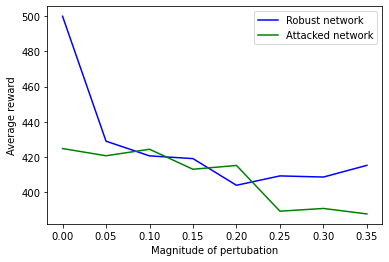

In [21]:
plt.figure(1)
plt.plot(epsilons_attacks,average_reward_number_robust, "-b",label = "Robust network")
plt.plot(epsilons_attacks,average_reward_number_attacked, "-g",label = "Attacked network")
plt.xlabel("Magnitude of pertubation")
plt.ylabel("Average reward")
plt.legend()
plt.show()

## Smooth like butter

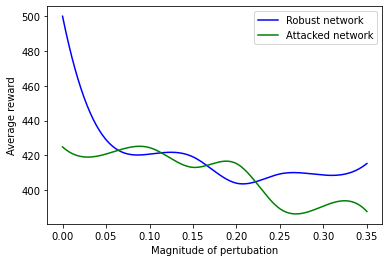

In [25]:
from scipy.interpolate import make_interp_spline, BSpline
plt.figure(2)
smooth_eps = np.linspace(epsilons_attacks.min(), epsilons_attacks.max(), 300)  
spl = make_interp_spline(epsilons_attacks,average_reward_number_robust , k=3) 
smooth_rewards_robust = spl(smooth_eps)
plt.plot(smooth_eps, smooth_rewards_robust, "-b", label = "Robust network")
spl_2 = make_interp_spline(epsilons_attacks,average_reward_number_attacked , k=3) 
smooth_rewards_attacked = spl_2(smooth_eps)
plt.plot(smooth_eps, smooth_rewards_attacked, "-g", label = "Attacked network")
plt.legend()
plt.xlabel("Magnitude of pertubation")
plt.ylabel("Average reward")
plt.show()